# Exploration of Classification Algorithms on Titanic Dataset

## Contents
* Part 1  - Import Packages and Data
* Part 2  - Feature Engineering and EDA
* Part 3  - Breakdown of Modelling Procedure
* Part 4  - Decision Tree
* Part 5  - KNN
* Part 6  - SVM
* Part 7  - Logistic Regression
* Part 8  - NB
* Part 9  - Random Forrest
* Part 10 - Overall Results and Conclusion

# Part 1 - Import packages and data

### 1.1 Import packages  

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### 1.2 Import Data

Data sourced from https://www.kaggle.com/c/titanic/data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

PassengerId = test_df['PassengerId'] #Store PassengerId for submission

# Part 2 - Feature Engineering and EDA

List of available features

| Variable     | Definition          |                  Key|
|--------------|---------------------|---------------------|
|survival      |	Survival         |     0 = No, 1 = Yes |
|pclass	       |Ticket class        |	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex|	_ |
|Age	|Age in years|	_ |
|sibsp|	  # of siblings/spouses	|_ |
|parch	|  # of parents/children	|_ |
|ticket	|Ticket number|	_ |
|fare|	Passenger fare|_ |
|cabin	|Cabin number|	_ |
|embarked|	Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton |

*Sourced from https://www.kaggle.com/c/titanic/data

In [20]:
#Check number of rows and columns
print('test ', test_df.shape) #418,11
print('train ',train_df.shape) #891,12

test  (418, 11)
train  (891, 12)


In [21]:
#Check if nulls exist in the data
print('Test variable null counts:\n',test_df.isnull().sum()) #Age, Fare and Cabin are Null in test
print('\nTrain variable null counts:\n', train_df.isnull().sum()) #Age, Cabin and Embarked are Null in train

Test variable null counts:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Train variable null counts:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Nulls exist which will need to be treated.

In [12]:
print(round(test_df.describe()))
print(round(train_df.describe()))

       PassengerId  Pclass    Age  SibSp  Parch   Fare
count        418.0   418.0  332.0  418.0  418.0  417.0
mean        1100.0     2.0   30.0    0.0    0.0   36.0
std          121.0     1.0   14.0    1.0    1.0   56.0
min          892.0     1.0    0.0    0.0    0.0    0.0
25%          996.0     1.0   21.0    0.0    0.0    8.0
50%         1100.0     3.0   27.0    0.0    0.0   14.0
75%         1205.0     3.0   39.0    1.0    0.0   32.0
max         1309.0     3.0   76.0    8.0    9.0  512.0
       PassengerId  Survived  Pclass    Age  SibSp  Parch   Fare
count        891.0     891.0   891.0  714.0  891.0  891.0  891.0
mean         446.0       0.0     2.0   30.0    1.0    0.0   32.0
std          257.0       0.0     1.0   15.0    1.0    1.0   50.0
min            1.0       0.0     1.0    0.0    0.0    0.0    0.0
25%          224.0       0.0     2.0   20.0    0.0    0.0    8.0
50%          446.0       0.0     3.0   28.0    0.0    0.0   14.0
75%          668.0       1.0     3.0   38.0    1.0


## 2.1 Treatment of existing features

1. Replace nulls in embarked with S
2. Replace nulls in age with average
3. Replace nulls in fare with average

In [3]:
#Create a copy of the original dataset
raw_train_df = train_df.copy()

#Removing nulls from embarked
train_df['Embarked'] = train_df['Embarked'].fillna('S')
test_df['Embarked'] = test_df['Embarked'].fillna('S')

#Removing nulls from Age
age_avg = train_df['Age'].mean()
train_df.loc[np.isnan(train_df['Age']), 'Age'] = age_avg
train_df['Age'] = train_df['Age'].astype(int)

age_avg = train_df['Age'].mean()
test_df.loc[np.isnan(test_df['Age']), 'Age'] = age_avg
test_df['Age'] = test_df['Age'].astype(int)

#Removing nulls from Fare
fare_avg = train_df['Fare'].mean()
train_df.loc[np.isnan(train_df['Fare']), 'Fare'] = fare_avg
train_df['Fare'] = train_df['Fare'].astype(int)

fare_avg = train_df['Fare'].mean()
test_df.loc[np.isnan(test_df['Fare']), 'Fare'] = fare_avg
test_df['Fare'] = test_df['Fare'].astype(int)


## 2.2 Creation of new features  

1. Flag for Has_cabin
2. Total family size (SibSp + Parch)
3. Lone traveller flag
4. Dummy variables for Embarked and Sex 

In [4]:
#Creating flag for cabin
train_df['Has_Cabin'] = train_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_df['Has_Cabin'] = test_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#Total family size
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

#Lone traveller flag
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1
test_df['IsAlone'] = 0
test_df.loc[test_df['FamilySize'] == 1, 'IsAlone'] = 1


cols_to_transform = [ 'Embarked', 'Sex' ]
test_df = pd.get_dummies(test_df ,columns = cols_to_transform )
train_df = pd.get_dummies(train_df ,columns = cols_to_transform )

#Drop columns and create final dataset
drop_elements = ['Cabin']
train_df = train_df.drop(drop_elements, axis = 1)
test_df  = test_df.drop(drop_elements, axis = 1)

## 2.3 EDA 

In [27]:
#Check final dataset for Nulls

print(test_df.isnull().values.any())
print(train_df.isnull().values.any())
#print(train_df.isnull().sum())



False
False


Ready to model!

# Part 3 - Breakdown of Modelling Procedure

We will train different models and will use Nested Cross validation to choose which model is best suited for our dataset. We will split the data initally into train - test so that we can compare the results of our models on the same test dataset.

1. Description
2. Simple Model
3. Variables ready 
4. Hyperparameter search
5. Final model results 
6. Test Result

In [5]:
#Drop columns and create final dataset
drop_elements = ['PassengerId', 'Name', 'Ticket']
train_df = train_df.drop(drop_elements, axis = 1)
test_df  = test_df.drop(drop_elements, axis = 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_df.iloc[:,1:], train_df.iloc[:,0],  stratify=train_df.iloc[:,0], test_size=0.20, random_state=1)

# Part 4 - Decision Tree


### 4.1 Decision Tree

Advantages
* Simple to understand
* White box model

Disadvantages
* Prone to overfitting
* Non-robust

In [ ]:
# Train a simple decision tree on the entire dataset

clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(train_df.iloc[:,1:], train_df.iloc[:,0])
scores = cross_val_score(clf, train_df.iloc[:,1:], train_df.iloc[:,0], cv=10)
print (round(scores.mean()*100,3),'%')

We see that we have an overall accuracy of 81.6%.

### Hyperparameter tuning

Now we use Gridsearch to find the best hyperparameters for the model.

The different hyperparameters that we can adjust in the Decision tree are:

1. max_depth: This controls how deep the tree can be
2. min_samples_split: The minimum number of samples required to split an internal node
3. min_samples_leaf: The minimum number of samples required to be a leaf node 
4. max_features: The number of features to consider when looking for a best split 
5. criterion_options = ["entropy", "gini"]

**External vs Internal Node**  
The difference between a leaf (also called external node) and an internal node is that an internal node will have further splits (also called children), while a leaf is a node without any children (without any further splits).

**Min_samples_split vs Min_samples_leaf**  
min_samples_split specifies the minimum number of samples required to split an internal node, while min_samples_leaf specifies the minimum number of samples required to be at a leaf node.

For instance, if min_samples_split = 5, and there are 7 samples at an internal node, then the split is allowed. But if the split results in two leaves, one with 1 sample, and another with 6 samples. If min_samples_leaf = 2, then the split won't be allowed (even if the internal node has 7 samples) because one of the leaves resulted will have less than the minimum number of samples required to be at a leaf node.

**Gini vs Entropy**

Gini is the probability of a random sample being classified incorrectly if we randomly pick a label according to the distribution in a branch.

\begin{equation*}
\textit{Gini}: 
\mathit{Gini}(E) = 1 - \sum_{j=1}^{c}p_j^2
\end{equation*}

Entropy on the other hand tries to maximize information gain.

\begin{align*}
\textit{Entropy}: H(E) = -\sum_{j=1}^{c}p_j\log p_j
\end{align*}

Information Gain=entropy(parent)–[average entropy(children)]


In [13]:
#Hyperparameter selection

max_depths = np.linspace(1, 10, 10, endpoint=True)
max_features = list(range(1,train_df.shape[1]))
min_samples_splits = np.linspace(1, 0, 10, endpoint=False)
min_samples_leafs = np.linspace(.5, 0, 5, endpoint=False)
criterion_options = ["entropy", "gini"]

parameter_grid_tree = {'max_depth': max_depths,
                  'max_features': max_features,
                  'min_samples_split' : min_samples_splits,
                  'min_samples_leaf' : min_samples_leafs,
                  'criterion' :criterion_options
                 }

dtc = DecisionTreeClassifier()

grid_search_tree = GridSearchCV(dtc, param_grid = parameter_grid_tree,cv=10, refit = True)                          
grid_search_tree.fit(X_train, y_train)
print ("Best Score: {}".format(grid_search_tree.best_score_))
print ("Best params: {}".format(grid_search_tree.best_params_))

Best Score: 0.7865168539325843
Best params: {'criterion': 'entropy', 'max_depth': 4.0, 'max_features': 7, 'min_samples_leaf': 0.19999999999999996, 'min_samples_split': 0.09999999999999998}


In [59]:
#Train final model
clf_final = tree.DecisionTreeClassifier(**grid_search_tree.best_params_)
clf_final = clf_final.fit(train_df.iloc[:,1:], train_df.iloc[:,0])
scores = cross_val_score(clf_final, train_df.iloc[:,1:], train_df.iloc[:,0], cv=10)
print ('Accuracy on the entire dataset:',round(scores.mean()*100,3),'%')

#Test the model 
y_true, y_pred = y_test, clf_final.predict(X_test) #Can use the gridsearch object as well
print('Accuracy on the Test dataset:',round(accuracy_score(y_true, y_pred)*100,2),'%')
print(classification_report(y_true, y_pred))

Accuracy on the entire dataset: 77.781 %
Accuracy on the Test dataset: 80.45 %
             precision    recall  f1-score   support

          0       0.83      0.85      0.84       110
          1       0.76      0.72      0.74        69

avg / total       0.80      0.80      0.80       179



In [52]:
pd.DataFrame(
    confusion_matrix(y_true, y_pred),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival'])

,Predicted Not Survival,Predicted Survival
True Not Survival,94,16
True Survival,19,50


In [60]:
#Output plots


One of the advantages of decision tree is that it provides a white box solution. Visualizing the the trees are helful in learning how these models work as well as interpreting the model. 

In [63]:
#Packages for plotting

from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from graphviz import Source
import dtreeviz
from dtreeviz.trees import *

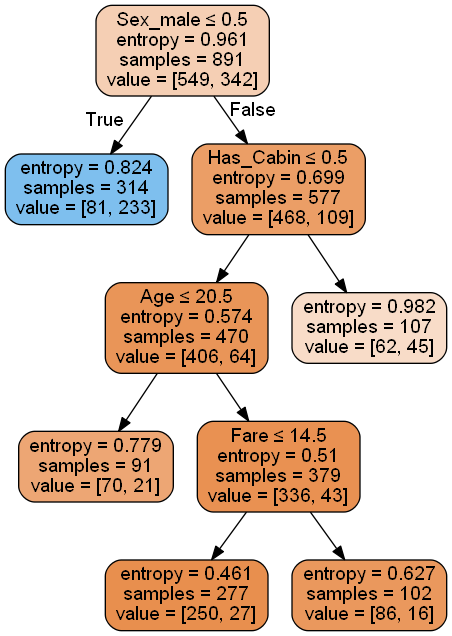

In [48]:
dot_data = StringIO()
export_graphviz(clf_final, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X_test.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

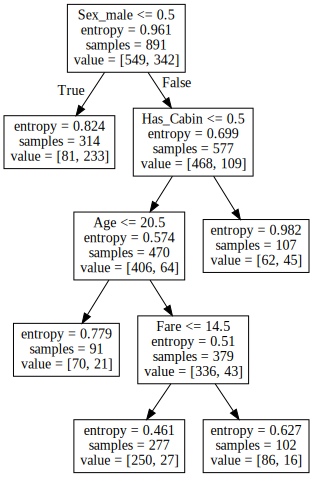

In [49]:
Source( tree.export_graphviz(clf_final, out_file=None, feature_names=X_test.columns))

Below is another way of visualizing the tree, it provides a nice summary of the target variable and the different feature at each stage. For more information- http://explained.ai/decision-tree-viz/index.html

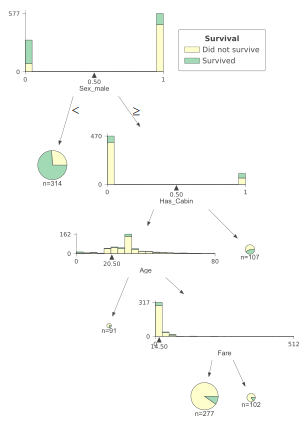

In [50]:
viz = dtreeviz(clf_final,train_df.iloc[:,1:], train_df.iloc[:,0], target_name='Survival',
               feature_names=X_train.columns,class_names=["Did not survive", "Survived"] )
viz.save("dtree.svg") 
# viz.view() will give give a popup with graph in pdf
viz

In [51]:
#Predict
test_predict = grid_search_tree.predict(test_df)

In [68]:
#Create submission file
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": test_predict
    })
submission.to_csv('submission.csv', index=False)

# Part 6 - SVM 

### Support Vector Machines

Advantages 
* Kernel trick, can specify custom kernels as well
* Convex optimisation problem
* SVM stores only the support vectors after training

Disadvantages
* Overfitting using Kernel
* Does not provide probability estimates

In [64]:
#Import packages
from sklearn import svm

#### Feature Scaling
SVMs assume that the data it works with is in a standard range, usually either 0 to 1, or -1 to 1 (roughly). So the normalization of feature vectors prior to feeding them to the SVM is very important.

We use fit_transform() on the train data so that we learn the parameters of scaling on the train data and in the same time we scale the train data. We only use transform() on the test data because we use the scaling paramaters learned on the train data to scale the test data.

In [ ]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std  = std_scale.transform(X_test)

#### Hyperparameter tuning for SVM

Now we use Gridsearch to find the best hyperparameters for the model.

The different hyperparameters that we can adjust in SVM are:

1. C: Penalty parameter C of the error term.
2. kernel: Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used by default.
3. gamma: Kernel coefficient ‘rbf’, ‘poly’ and ‘sigmoid’.




In [ ]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid_svm = {'C': Cs, 'gamma' : gammas,'kernel': ['linear', 'rbf','poly']  }
grid_search_svm = GridSearchCV(svm.SVC(), param_grid_svm, cv=10)
grid_search_svm.fit(X_train, y_train)
grid_search_svm.best_params_


In [ ]:
http://scikit-learn.org/stable/modules/compose.html